# Fruit Classifier

## 1. Import Necessary Libraries

In [14]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Device configuration
# Apple silicon macbook MPS (Metal Performance Shaders)
device = torch.device('mps' if torch.mps.is_available else 'cpu')
print(f"Using device: {device}")

Using device: mps


## 2. Data Loading and Preprocessing

### Define Directories

In [16]:
# Define directories
train_dir = 'train'  # Path to your training data
test_dir = 'test'    # Path to your test data

### Define Transformations

In [17]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(),     # Random horizontal flip
    transforms.RandomRotation(10),         # Random rotation
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406],   # Normalize with ImageNet mean and std
                         [0.229, 0.224, 0.225])
])

# Just normalization for validation/testing
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Load Datasets

In [18]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Get class names
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['apple', 'banana', 'mixed', 'orange']


### Check Class Distribution

In [19]:
from collections import Counter

# Training set class distribution
train_counts = Counter([label for _, label in train_dataset])
print("Training class distribution:", train_counts)

# Test set class distribution
test_counts = Counter([label for _, label in test_dataset])
print("Test class distribution:", test_counts)

/Users/benben/.pyenv/versions/3.12.4/envs/benmain/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training class distribution: Counter({0: 75, 3: 73, 1: 72, 2: 20})
Test class distribution: Counter({0: 19, 1: 18, 3: 18, 2: 5})


### Balancing Classes

In [20]:
# Calculate weights for each class
total_train_samples = len(train_dataset)
class_weights = []
for c in range(len(class_names)):
    class_count = train_counts[c]
    class_weight = total_train_samples / (len(class_names) * class_count)
    class_weights.append(class_weight)

# Assign weights to each sample
sample_weights = [class_weights[label] for _, label in train_dataset]

# Create sampler
from torch.utils.data.sampler import WeightedRandomSampler
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

## 3. Data Loaders

In [21]:
# Define batch size
BATCH_SIZE = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 4. Visualize Some Training Images

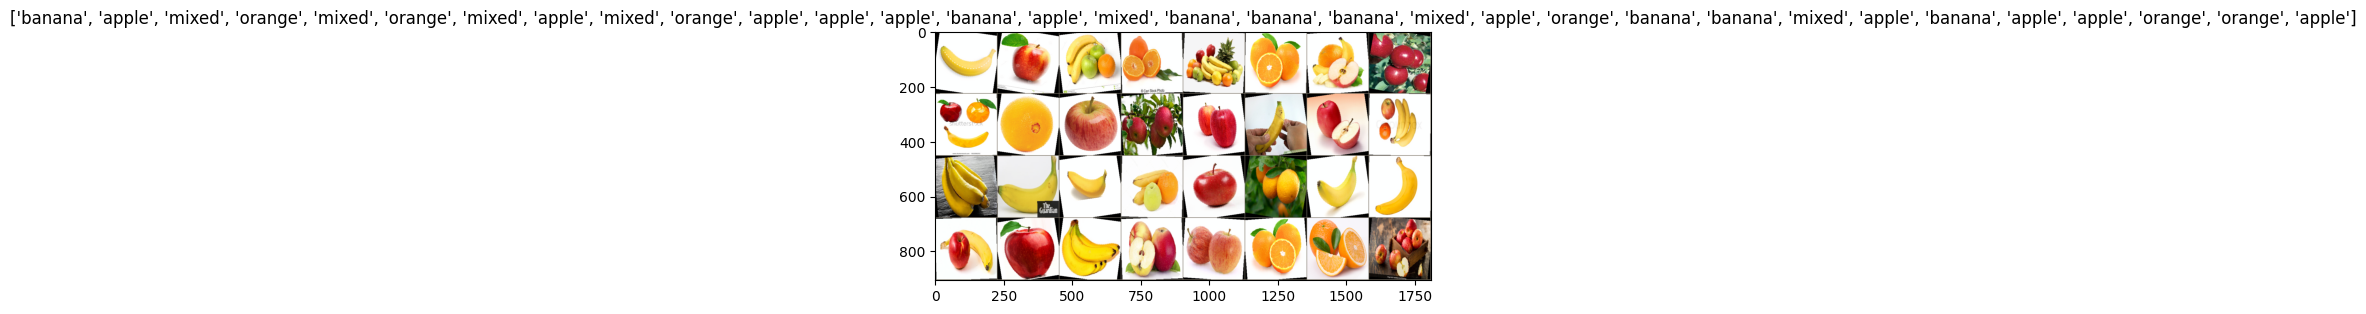

In [22]:
# Function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp * np.array([0.229, 0.224, 0.225]) +
                  np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the images
imshow(out, title=[class_names[x] for x in classes])

## Define the CNN Model

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        # Adjusted in_channels to 3 for RGB images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjusted in_features based on the output size after convolutions and pooling
        self.fc1 = nn.Linear(in_features=16*16*32, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolution + ReLU + pooling layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the feature maps for the fully connected layer
        x = x.view(-1, 16 * 16 * 32)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
def train(model, criterion, optimizer, filepaths, labels, batch_size=32, n_epochs=10):
    model.train()
    total_samples = len(filepaths)
    for epoch in range(n_epochs):
        # For tracking progress
        samples_trained = 0
        running_loss = 0.0
        correct_preds = 0

        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images(filepaths[indices])
            batch_labels = labels[indices]
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            running_loss += loss.item() * batch_labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == batch_labels).item()
            samples_trained += batch_labels.size(0)

            # Print progress
            if (i // batch_size) % 10 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i//batch_size}], " +
                      f"Loss: {loss.item():.4f}")

        epoch_loss = running_loss / samples_trained
        epoch_acc = correct_preds / samples_trained * 100
        print(f"Epoch [{epoch+1}/{n_epochs}] completed. " +
              f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%\n")